# Experience Models

# I. THINGS before model
## 1. EDA

Preparing

In [1]:
!pip install pycm livelossplot
from livelossplot import PlotLosses
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import numpy as np
import os
import glob
import random


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.8/599.8 kB 25.5 MB/s eta 0:00:00
No GPU available!


Creat the dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def extract_index(filename):
    # Extract the numeric part of the filename (assumes format like 'bkh_000.jpg' or 'bkh_005 (1).jpg')
    parts = os.path.basename(filename).split('_')[1].split('.')[0]
    # Keep only digits
    numeric_part = ''.join(filter(str.isdigit, parts))
    return int(numeric_part)

base_path = '/content/drive/MyDrive/storms_olga'
subdirectories = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

data_pairs = []
for subdir in subdirectories:
    # Load the CSV file for each storm
    csv_path = os.path.join(base_path, subdir, f'{subdir}_data.csv')
    data = pd.read_csv(csv_path)
    index_to_speed = dict(zip(data['index'], data['wind_speed']))

    # Load images and pair them with their wind speed
    files = sorted(glob.glob(os.path.join(base_path, subdir, '*.jpg')))
    for filepath in files:
        img = np.array(Image.open(filepath))
        # Extract the index using the custom function and get the corresponding wind speed
        index = extract_index(filepath)
        wind_speed = index_to_speed.get(index)
        if wind_speed is not None:
            data_pairs.append((img, wind_speed))

# Convert the list of pairs into a NumPy array
# Note: This step may require adjustments depending on how you want to use the data
dataset = np.array(data_pairs, dtype=object)

Check the dataset


Shape: (9780, 2)
Data Type: object
Number of Elements: 19560
Number of Dimensions: 2


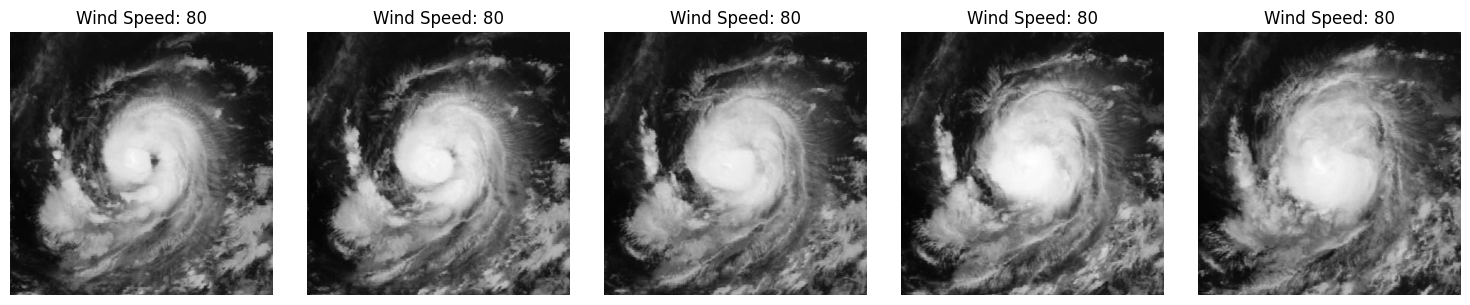

In [6]:
#print("Array:", dataset)
print("\nShape:", dataset.shape)
print("Data Type:", dataset.dtype)
print("Number of Elements:", dataset.size)
print("Number of Dimensions:", dataset.ndim)

import matplotlib.pyplot as plt

# Assuming 'dataset' is your NumPy array containing the (image, wind_speed) pairs
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
for i in range(200, 205):
    img, wind_speed = dataset[i]
    axes[i-200].imshow(img, cmap= "gray")
    axes[i-200].set_title(f"Wind Speed: {wind_speed}")
    axes[i-200].axis('off')

plt.tight_layout()
plt.show()

## 2. Dataloader
Creat the dataloader

In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import numpy as np
from PIL import Image

class HurricaneDataset(Dataset):
    def __init__(self, data_pairs, transform=None, augment=False):
        self.data_pairs = data_pairs
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        img, wind_speed = self.data_pairs[idx]
        img = Image.fromarray(img)

        # Apply transformation
        if self.transform:
            img = self.transform(img)

        # Apply rotation augmentation if augment is True
        if self.augment:
            rotation_angle = random.choice([90, 180, 270])
            img = transforms.functional.rotate(img, rotation_angle)

        return img, wind_speed

# Data Transforms (can be modified as per requirement)
transform = transforms.Compose([
    transforms.Resize((366, 366), antialias=True),  # Resize to the input size expected by your model
    transforms.Grayscale(),  # Convert image to grayscale
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create the dataset
hurricane_dataset = HurricaneDataset(data_pairs, transform=transform)
dataloader = DataLoader(hurricane_dataset, batch_size=64, shuffle=True)

Check the dataloader

In [8]:
# check the dataloader
# Iterate over the dataloader and print the first batch
for images, wind_speeds in dataloader:
    print(f"Batch Size: {len(images)}")
    print("Dataloader:", dataloader)
    print("Dataloader type:", type(dataloader))
    print(f"Image Shape: {images[0].size()}")
    print(f"Wind Speeds: {wind_speeds}")
    print(len(dataloader))
    break  # Only show the first batch


Batch Size: 64
Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x79e633bf01f0>
Dataloader type: <class 'torch.utils.data.dataloader.DataLoader'>
Image Shape: torch.Size([1, 366, 366])
Wind Speeds: tensor([ 35.,  47.,  84.,  63.,  34.,  40.,  88.,  95.,  25.,  25.,  66.,  65.,
         60.,  30., 130., 111.,  50.,  68.,  57.,  30.,  65.,  44.,  35.,  65.,
         60.,  88., 100., 100.,  36.,  28.,  66.,  40.,  25.,  25.,  56., 106.,
         64., 107.,  98.,  60.,  58.,  23.,  21.,  38.,  41.,  35.,  35.,  25.,
         69.,  58.,  71.,  55.,  25.,  45.,  30.,  55.,  36.,  25.,  60.,  30.,
         31.,  30.,  65.,  75.])
153


## 3. Split the dataloader - train & test dataloader

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset, DataLoader

# Assuming your dataset is a list of (image, label) tuples
all_labels = [label for _, label in dataset]

# Create the StratifiedShuffleSplit object
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get indices for train and validation sets
train_indices, val_indices = next(splitter.split(list(range(len(dataset))), all_labels))




# Create subsets for training and validation
train_subset = Subset(hurricane_dataset, train_indices)
val_subset = Subset(hurricane_dataset, val_indices)



train_dataset = HurricaneDataset(train_subset, transform=transforms, augment=True)
val_dataset = HurricaneDataset(val_subset, transform=transforms, augment=False)

# DataLoader wraps the dataset to provide batching, shuffling, and multiprocessing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Check the train_loader

data type of train_loader: <class 'torch.utils.data.dataloader.DataLoader'>
Batch size of train_loader: 64
Number of batches of train_loader: 123
Num images in train_loader: 7872
Typr of image: <class 'torch.Tensor'>
Image shape in train_loader: torch.Size([64, 1, 366, 366])
Range of train_loader: max, 1.0 min,-1.0
Num pixels in train_loader: 366


Text(0.5, 1.0, 'train_dataloader_example')

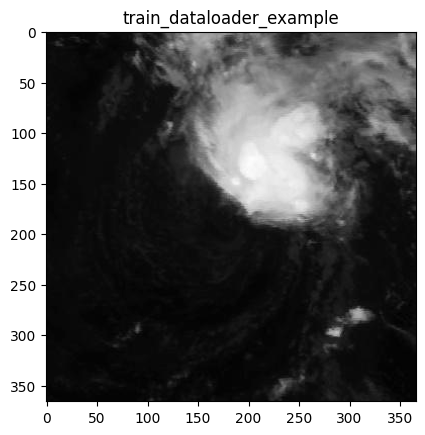

In [12]:
from torchvision.utils import make_grid

print(train_loader)
print('data type of train_loader:', type(train_loader))
print('Batch size of train_loader: '+str(train_loader.batch_size))
print('Number of batches of train_loader: '+str(train_loader.__len__()))
print('Num images in train_loader: '+str(train_loader.batch_size*train_loader.__len__()))
print('Typr of image:', type(images))
print('Image shape in train_loader: ' + str(images.shape))
print('Range of train_loader: max, '+str(float(images.max()))+' min,'+str(float(images.min())))
print('Num pixels in train_loader: '+str(images.shape[1]*images.shape[2]))

# Plot the first image in the batch - Visualise a batch sample
plt.imshow(images[0].squeeze(), cmap = "gray")
plt.title('train_dataloader_example')

Check the test_loader

data type of test_loader: <class 'torch.utils.data.dataloader.DataLoader'>
Batch size of test_loader: 64
Number of batches of test_loader: 31
Num images in test_loader: 1984
Typr of image: <class 'torch.Tensor'>
Image shape in test_loader: torch.Size([64, 1, 366, 366])
Range of test_loader: max, 1.0 min,-1.0
Num pixels in test_loader: 366


Text(0.5, 1.0, 'test_dataloader_example')

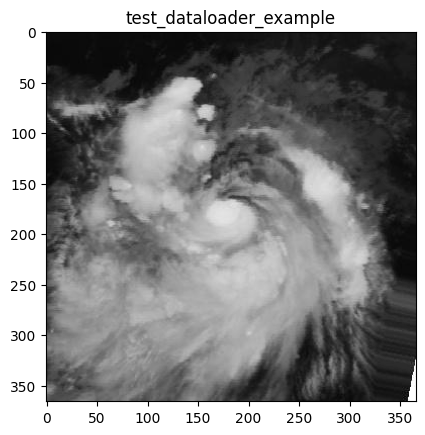

In [13]:
print(test_loader)
print('data type of test_loader:', type(test_loader))
print('Batch size of test_loader: '+str(test_loader.batch_size))
print('Number of batches of test_loader: '+str(test_loader.__len__()))
print('Num images in test_loader: '+str(test_loader.batch_size*test_loader.__len__()))
print('Typr of image:', type(images))
print('Image shape in test_loader: ' + str(images.shape))
print('Range of test_loader: max, '+str(float(images.max()))+' min,'+str(float(images.min())))
print('Num pixels in test_loader: '+str(images.shape[1]*images.shape[2]))

# Plot the third image in the batch - Visualise a batch sample
plt.imshow(images[3].squeeze(),cmap="gray" )
plt.title('test_dataloader_example')

## 4. Train and validate functions

In [14]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from livelossplot import PlotLosses

def train(model, optimizer, criterion, data_loader, device):
    model.train()
    train_loss = 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device).float().view(-1, 1)
        optimizer.zero_grad()
        predictions = model(X)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X.size(0)
        print(train_loss)

    return train_loss / len(data_loader.dataset)

def validate(model, criterion, data_loader, device):
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device).float().view(-1, 1)
            predictions = model(X)
            loss = criterion(predictions, y)
            validation_loss += loss.item() * X.size(0)

    return validation_loss / len(data_loader.dataset)

def evaluate(model, data_loader, device):
    model.eval()
    actuals, predictions = [], []
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device).float().view(-1, 1)
            preds = model(X)
            actuals.append(y.cpu().numpy())
            predictions.append(preds.cpu().numpy())

    actuals = np.concatenate(actuals, axis=0)
    predictions = np.concatenate(predictions, axis=0)
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)

    return mse, mae, actuals, predictions

In [15]:
def train_model(model, train_subset, val_subset, n_epochs, lr, batch_size, device):
    # Set the seed for reproducibility


    # Model, optimizer, and loss function
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = torch.nn.MSELoss()

    # Data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)

    # Plot losses

    lowest_val_loss = float('inf')
    best_epoch = 0

    liveloss = PlotLosses()
    for epoch in range(n_epochs):
        logs = {}

        # Training
        train_loss = train(model, optimizer, criterion, train_loader, device)
        logs['loss'] = train_loss

        # Validation
        validation_loss = validate(model, criterion, val_loader, device)
        logs['val_loss'] = validation_loss

        # Check if this is the best model (lowest validation loss so far)
        if validation_loss < lowest_val_loss:
            lowest_val_loss = validation_loss
            best_epoch = epoch
            # Save the model at this epoch
            torch.save(model.state_dict(), 'best_model_state_dict.pth')

        # Update and draw the live plot
        liveloss.update(logs)
        liveloss.send()

    print(f"Best model saved from epoch {best_epoch} with validation loss: {lowest_val_loss}")
    return model

# II. MODELS

## 1. Simple CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(SimpleCNN, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Define pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Define fully connected layers
        self.fc1 = nn.Linear(64 * 16 * 16, 512) # Assuming the input image size is 128x128
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Apply convolutional and pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the feature maps
        x = x.view(x.size(0), -1)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

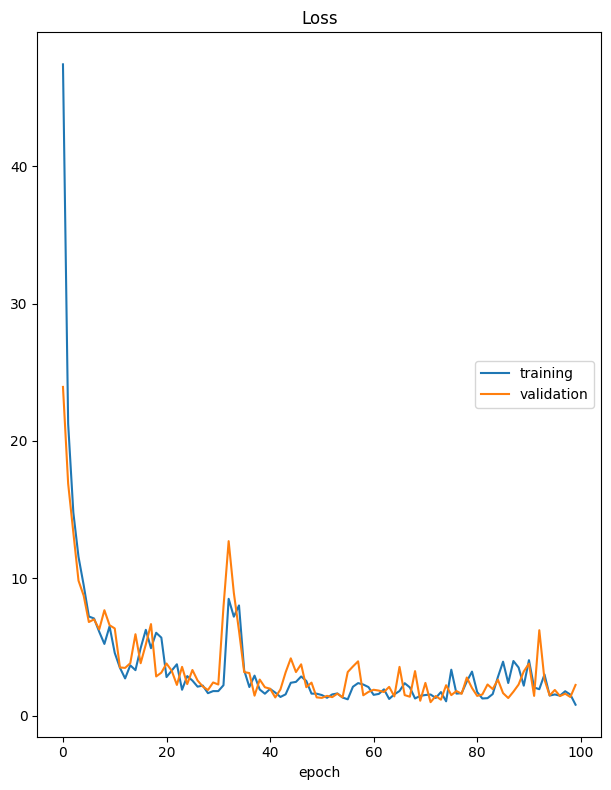

Loss
	training         	 (min:    0.798, max:   47.418, cur:    0.798)
	validation       	 (min:    0.983, max:   23.934, cur:    2.237)
Training completed.


In [ ]:
# Define other hyperparameters
n_epochs = 100
lr = 0.001
batch_size = 16
device = 'cuda'  # 'cuda' for GPU or 'cpu' for CPU
model = SimpleCNN(num_classes=1) # Create model instance

train_model(model, train_dataset, val_dataset, n_epochs, lr, batch_size, device)

## 2. CNN - Google
some adjustics, from google

In [ ]:
class CNN_linkedin(nn.Module):
    def __init__(self):
        super(CNN_linkedin, self).__init__()
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=64 * 32 * 32, out_features=512)  # Adjusted for 128x128 input
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=1)
    def forward(self, x):
        # Apply conv layer, batch norm, Leaky ReLU, max pool and dropout
        x = self.dropout1(self.pool1(F.leaky_relu(self.bn1(self.conv1(x)))))
        x = self.dropout2(self.pool2(F.leaky_relu(self.bn2(self.conv2(x)))))
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)  # Flatten
        # Fully connected layers with dropout
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)  # No activation function, direct regression output
        return x

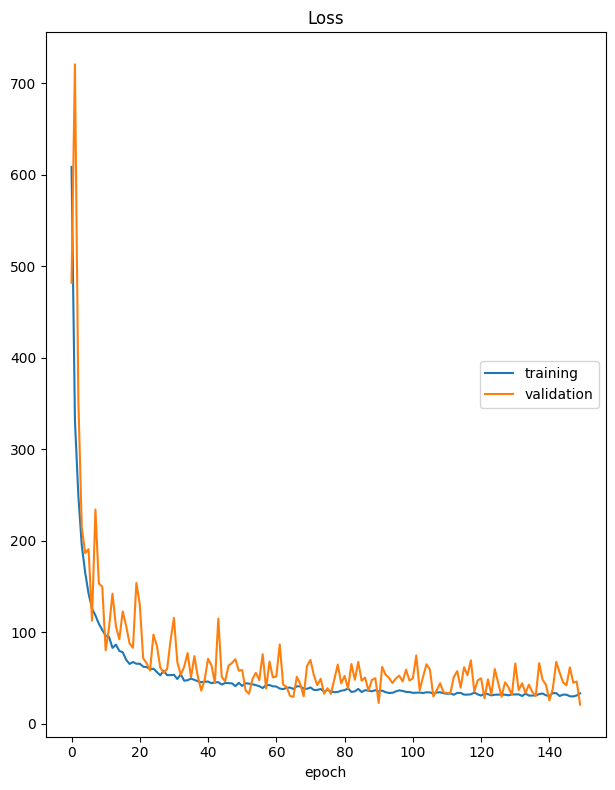

Loss
	training         	 (min:   29.806, max:  608.391, cur:   33.147)
	validation       	 (min:   20.765, max:  720.478, cur:   20.765)
Model saved from the last epoch


In [ ]:
n_epochs = 150  # Number of epochs
lr = 0.000007  # Learning rate
batch_size = 64  # Batch size
model5 = CNN_linkedin().to(device)

# Train the model
trained_model5 = train_model(model5, train_subset, val_subset, n_epochs, lr, batch_size, device)

## 3. CNN + LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models

class CNNLSTM(nn.Module):
    def __init__(self, num_classes=1):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.lstm = nn.LSTM(input_size=32*32*32, hidden_size=128, num_layers=1, batch_first=True)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        batch_size, seq_length, C, H, W = x.size()
        c_in = x.view(batch_size * seq_length, C, H, W)
        c_out = self.cnn(c_in)
        c_out = c_out.view(batch_size, seq_length, -1)

        lstm_out, (h_n, c_n) = self.lstm(c_out)
        out = self.fc(lstm_out[:, -1, :])
        return out

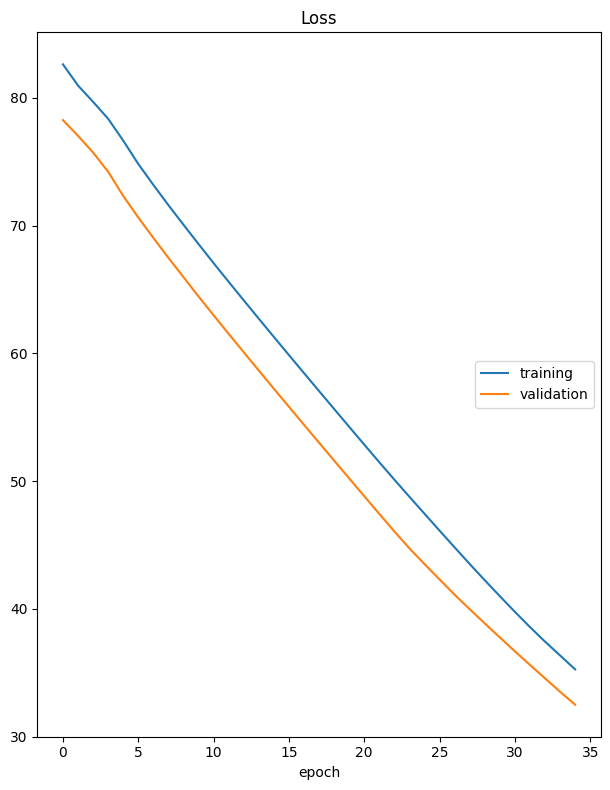

Loss
	training         	 (min:   35.269, max:   82.620, cur:   35.269)
	validation       	 (min:   32.504, max:   78.254, cur:   32.504)


In [ ]:
# Define other hyperparameters
n_epochs = 100
lr = 0.001
batch_size = 16
device = 'cuda'  # 'cuda' for GPU or 'cpu' for CPU
model = CNNLSTM(num_classes=1)

train_model(model, train_dataset, val_dataset, n_epochs, lr, batch_size, device)



## 4. Resnet 18

In [ ]:
import torch
import torch.nn as nn

# Basic Block for ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# ResNet-18 architecture for 32x32 input size
class ResNet18(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * BasicBlock.expansion
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

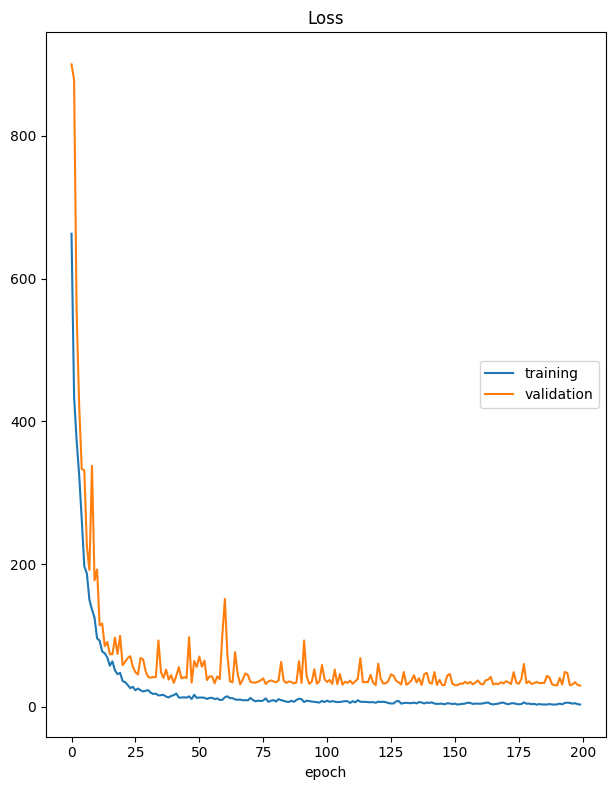

Loss
	training         	 (min:    3.125, max:  662.784, cur:    3.349)
	validation       	 (min:   29.869, max:  900.093, cur:   29.869)
Best model saved from epoch 199 with validation loss: 29.869271943851885


In [ ]:
n_epochs = 200  # Number of epochs
lr = 0.00015  # Learning rate
batch_size = 64  # Batch size
model = ResNet18(num_classes = 1).to(device)

# Train the model
trained_model = train_model(model, train_subset, val_subset, n_epochs, lr, batch_size, device)

## 5. Resnet 18 - better one

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models  # Import the models module from torchvision

class ResNetModel(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNetModel, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = models.resnet18(pretrained=True)

        # Replace the last fully connected layer to fit our single class output
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)


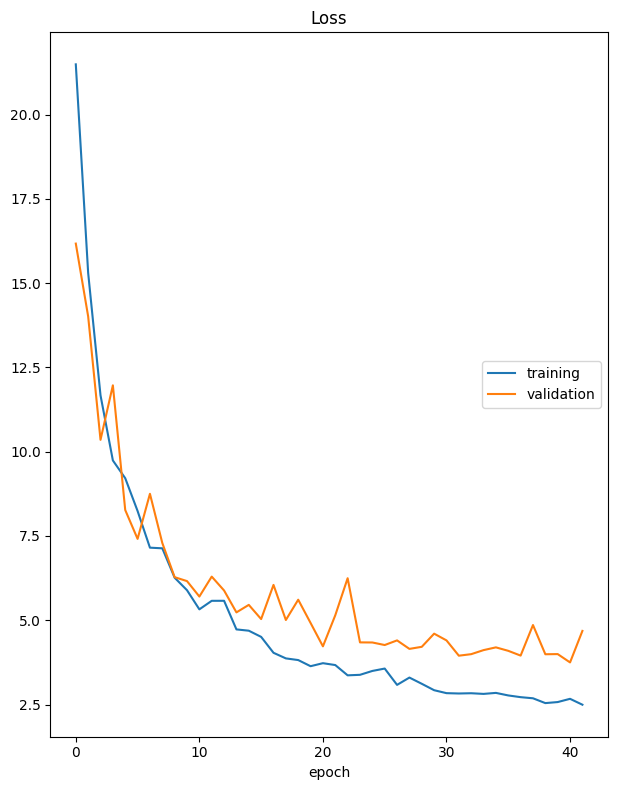

Loss
	training         	 (min:    2.494, max:   21.490, cur:    2.494)
	validation       	 (min:    3.748, max:   16.173, cur:    4.683)


Training:  98%|█████████▊| 420/428 [00:15<00:00, 26.97it/s]

In [ ]:
# Define other hyperparameters
n_epochs = 100
lr = 0.001
batch_size = 16
device = 'cuda'  # 'cuda' for GPU or 'cpu' for CPU
model = ResNetModel(num_classes=1) # Create model instance

train_model(model, train_dataset, val_dataset, n_epochs, lr, batch_size, device)

## 6. Resnet 50

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class CustomResNetModel(nn.Module):
    def __init__(self, num_classes=1):
        super(CustomResNetModel, self).__init__()
        # Load a pre-trained ResNet50 model
        self.resnet = models.resnet50(pretrained=True)

        # Replace the last fully connected layer to fit our single class output
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)


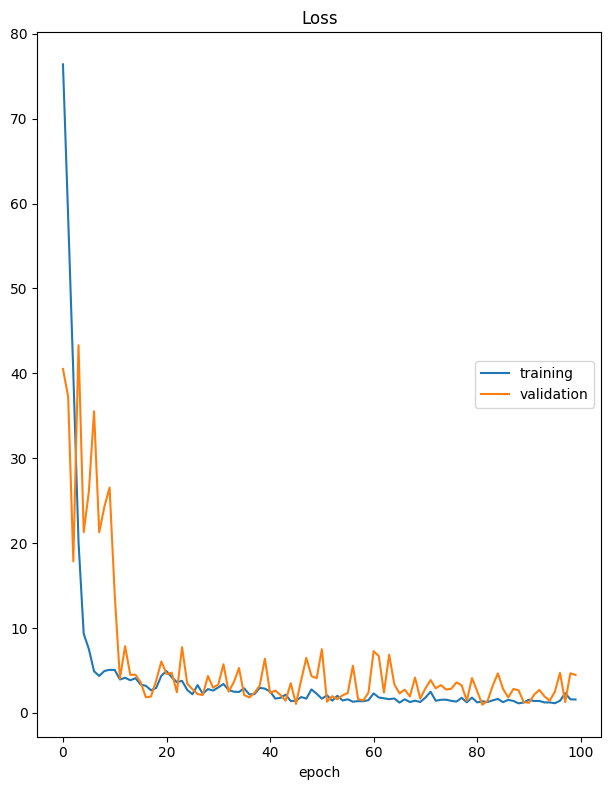

Loss
	training         	 (min:    1.130, max:   76.391, cur:    1.583)
	validation       	 (min:    0.972, max:   43.319, cur:    4.475)
Training completed.


In [ ]:

# Define other hyperparameters
n_epochs = 100
lr = 0.001
batch_size = 16
device = 'cuda'  # 'cuda' for GPU or 'cpu' for CPU
model = CustomResNetModel(num_classes=1) # Create model instance

train_model(model, train_dataset, val_dataset, n_epochs, lr, batch_size, device)



# Conclusion

In the end, we choose the simple CNN model (the first one). This is because:
1. It has the lowest RMSE.
2. It preserved the best prediction.